<h1> Implémentation du schéma de Rusanov - CAS 2D </h1>

Voici le code à partir duquel nous avons obtenu les graphes du rapport. Ce code permet aussi de générer des fichier .gif et ainsi de visualiser les évolutions (hauteur d'eau et débit) au cours du temps.

<h2>Équations dans le cas 2D :</h2>

$$ \frac{\partial h}{\partial t} + \frac{\partial hu}{\partial x} + \frac{\partial hv}{\partial y} = 0$$

$$ \frac{\partial hu}{\partial t} + \frac{\partial}{\partial x} ( hu^2 + \frac{gh^2}{2} ) + \frac{\partial}{\partial y} ( huv + \frac{gh^2}{2} ) = 0$$

$$ \frac{\partial hv}{\partial t} + \frac{\partial}{\partial x} ( huv + \frac{gh^2}{2} ) + \frac{\partial}{\partial y} ( hv^2 + \frac{gh^2}{2} ) = 0$$

## Importations

In [1]:
import math as math # Pour les fonctions math

import matplotlib.pyplot as plt # Pour l'affichage des graphes
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from mpl_toolkits import mplot3d 

plt.rc('font', size=20)

import numpy as np # Pour les tableaux numpy
import imageio # Pour faire des .gif

## Paramètres du problème

In [29]:
g=1 # Constante gravitationnelle

xMin=0 # Bord gauche du domaine
xMax=100 # Bord droit du domaine

yMin = 0 #Bord bas du domaine
yMax = 100 #Bord haut du domaine

N=64 # Nombre de points (strictement à l'intérieur)
# Donc au total, on considère (N+2)^2 points avec les bords

h=(xMax-xMin)/(N+1) # Pas du maillage spatial, le même pour X et Y

Tmax = 12 # Temps final de la simulation
t=0 # Temps dans la simulation
n=0 # Nombre d'itérations

## Conditions initiales et Topographie

Dans la cellule ci-dessous, nous définissons la discrétisation de l'axe des abscisses $\textbf{X}$, ainsi que la topographie $\textbf{Z}$ et les profils initiaux de la hauteur d'eau $h$ et des débits $hu$ et $hv$ selon $x$ et $y$ respectivement. Le code en commentaire correspond à différentes initialisations possibles. Pour le suite, notons 
$\textbf{W}=
\begin{pmatrix}
   h \\
   hu \\
   hv \\
\end{pmatrix}
\in\mathbb{R}^{3}$ 
le vecteur inconnu.

In [30]:
X,Y=np.mgrid[xMin:xMax+2*h/3:h,yMin:yMax+2*h/3:h] # Discrétisation de [xMin, xMax] et [yMin, yMax]

W0 = np.ones([N+2,N+2]) # Discrétisation de h
W1 = np.ones([N+2,N+2]) # Discrétisation de hu
W2 = np.ones([N+2,N+2]) # Discrétisation de hv

W0prime = np.ones([N+2,N+2]) # Pour les calculs dans la boucle temporelle
W1prime = np.ones([N+2,N+2]) 
W2prime = np.ones([N+2,N+2]) 

# Définitions du h initial ------------------------------------

# Hauteur de l'eau en escalier 
# W0[0,0:(N+2)//3]   = 3
# W0[0,(N+2)//3:N+2] = 1.25

# Hauteur de l'eau constante
# W0[0,:]=1

# Hauteur de l'eau en bosse
W0 = 2+5/(4 + .01*( (X-50)**2 + (Y-50)**2 ) )


# Définitions du débit initial ------------------------------------

# Débit de l'eau constant
W1[:,:]=0
W2[:,:]=0

## Nombre de sauvegardes durant la simulation

Quelques variables qui vont nous servir pour enregistrer des étapes de la simulation, sans pour autant les sauvegarder toutes. Sans ça, le nombre d'images à sauver deviendrait vite trop important. De plus, l'affichage ne serait pas uniforme dans le temps car certains passages de la simulation nécessitent des pas de temps plus petits.

In [31]:
nSauvegarde=100 # Nombre de sauvegardes au cours de la simulation
tSauvegarde=[False for i in range(nSauvegarde)]

imageH=[]
imageHU=[]
imageHV=[]

k=0 # Nombre de sauvegardes déjà effectuées

## Affichage des images

La fonction ci-dessous permet de gérer l'affichage de la solution. Elle est suivie d'un test. Les graphes qui s'affichent sont ceux de $h$ et $q$ à $t=0$.

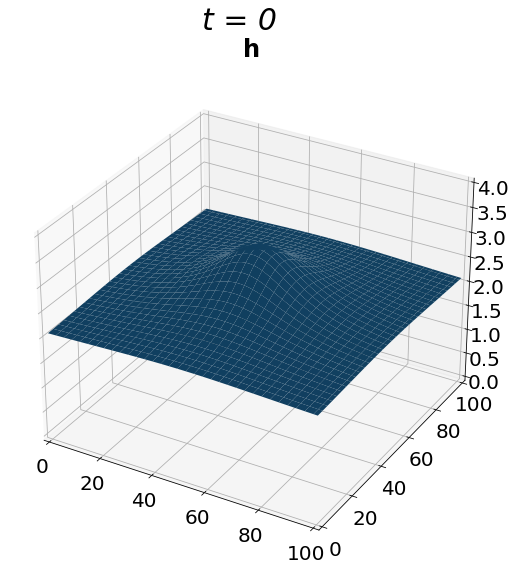

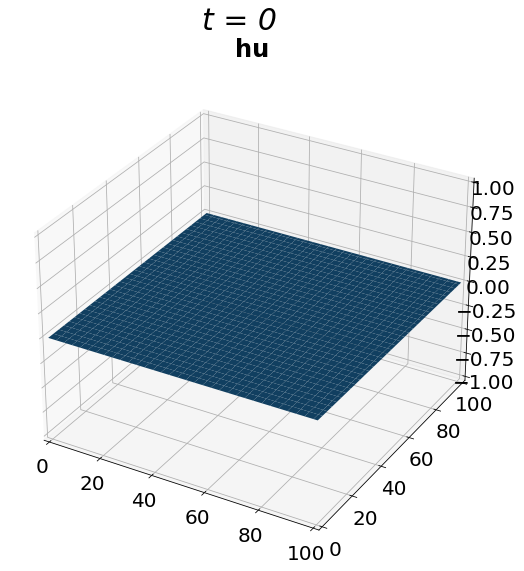

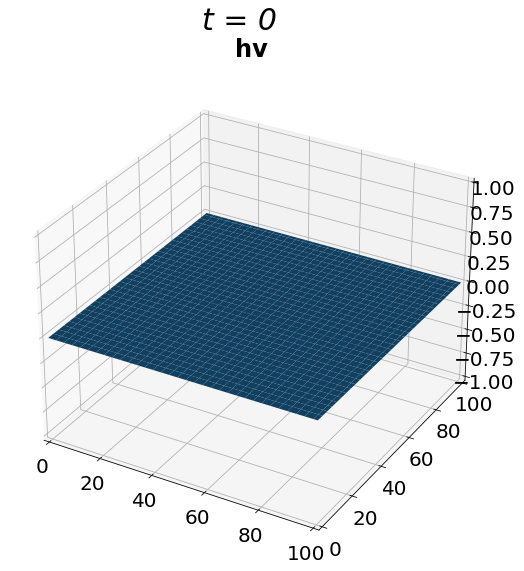

In [25]:
def affiche_W(t=0,index=0):
    
    #index : suivant que l'on veuille afficher h, u ou v
    
    t_int=round(t,4) # Troncature de t après la 4eme décimale
    
    fig = plt.figure(figsize =(14, 9)) 
    ax = plt.axes(projection ='3d') 

    if(index==0):
        ax.plot_surface(X, Y, W0) 
        ax.set_title("h",fontweight="bold",pad=15)
        ax.set_zlim([0,4])
    elif(index==1):
        ax.plot_surface(X, Y, W1)
        ax.set_title("hu",fontweight="bold",pad=15)
        ax.set_zlim([-1,1])
    elif(index==2):
        ax.plot_surface(X, Y, W2)
        ax.set_title("hv",fontweight="bold",pad=15)
        ax.set_zlim([-1,1])
    else:
        print("Mauvaise valeur d'index")
        
    fig.suptitle("t = "+str(t_int),style='italic',size=30)
            
    ax.set_xlim([xMin,xMax])
    ax.set_ylim([yMin,yMax])
        
    plt.show()
    
#Affichage de h, u et v
affiche_W()
affiche_W(index=1)
affiche_W(index=2)

## Sauvegarde des images

_enregistre_W_ effectue un traitement identique à _affiche_W_. La seule différence est qu'elle enregistre le plot dans le répertoire courant plutôt que de l'afficher.

In [26]:
def enregistre_W(t,index=0):

    t_int=round(t,4) # Troncature de t après la 4eme décimale
      
    fig = plt.figure(figsize =(14, 9)) 
    ax = plt.axes(projection ='3d') 

    if(index==0):
        ax.plot_surface(X, Y, W0) 
        ax.set_title("h",fontweight="bold",pad=15)
        ax.set_zlim([0,4])
    elif(index==1):
        ax.plot_surface(X, Y, W1)
        ax.set_title("hu",fontweight="bold",pad=15)
        ax.set_zlim([-1,1])
    elif(index==2):
        ax.plot_surface(X, Y, W2)
        ax.set_title("hv",fontweight="bold",pad=15)
        ax.set_zlim([-1,1])
    else:
        print("Mauvaise valeur d'index")
        
    fig.suptitle("t = "+str(t_int),style='italic',size=30)
            
    ax.set_xlim([xMin,xMax])
    ax.set_ylim([yMin,yMax])
    
    fig.canvas.draw()
    image_from_plot=np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot=image_from_plot.reshape(fig.canvas.get_width_height()[::-1]+(3,))
    
    if(index==0):
        imageH.append(image_from_plot)
    elif(index==1):
        imageHU.append(image_from_plot)
    elif(index==2):
        imageHV.append(image_from_plot)
    
    plt.close()
    
enregistre_W(0,index=0)
enregistre_W(0,index=1)
enregistre_W(0,index=2)

<h2> Fonctions intervenant dans le schéma </h2>

En posant : $W = \left[ {\begin{array}{c}   h \\    hu \\    hv \\  \end{array} } \right] $ ; $ F(W) = \left[ {\begin{array}{c}   hu \\    hu^2 + \frac{gh^2}{2}  \\    huv + \frac{gh^2}{2} \\  \end{array} } \right] $ ; $ G(W) = \left[ {\begin{array}{c}   hv \\    huv + \frac{gh^2}{2}  \\    hv^2 + \frac{gh^2}{2} \\  \end{array} } \right] $ 

Avec $h$ la hauteur de l'eau, $u$ sa vitesse suivant la direction $x$ et $v$ sa vitesse suivant la direction $y$.

On a le système suivant :

$$ \frac{\partial W}{\partial t} + \frac{\partial F(W)}{\partial x} + \frac{\partial G(W)}{\partial y} = 0 $$

En identifiant $F(W)$ au flux suivant $x$ et $G(W)$ au flux suivant $y$.

En s'inspirant de ce qui a été fait dans le cas 1D, on discrétise de la manière suivante :

$$ \frac{ W_{i,j}^{n+1} - W_{i,j}^{n} }{\Delta t} + \frac{ F_{i+\frac{1}{2},j}^{n} -  F_{i-\frac{1}{2},j}^{n} }{\Delta x} + \frac{G_{i,j+\frac{1}{2}}^{n} -  G_{i,j-\frac{1}{2}}^{n} }{\Delta y} = 0 $$

Ce qui nous donne finalement :

$$  W_{i,j}^{n+1} = W_{i,j}^n - \frac{\Delta t}{\Delta x} ( F_{i+\frac{1}{2},j}^{n} -  F_{i-\frac{1}{2},j}^{n} ) - \frac{\Delta t}{\Delta y} ( G_{i,j+\frac{1}{2}}^{n} -  G_{i,j-\frac{1}{2}}^{n} ) $$

Avec : 

$$ F_{i+\frac{1}{2},j} =  \frac{ F(W_{i+1,j}) + F(W_{i,j}) }{2} - c \frac{ W_{i+1,j} - W_{i,j} }{2} \quad où \quad c = \sup_{W =  W_{i,j} ,  W_{i+1,j}} \sup_{k = 1,2} | \lambda _k(W) | $$

et

$$ G_{i,j+\frac{1}{2}} =  \frac{ G(W_{i,j+1}) + G(W_{i,j}) }{2} - c \frac{ W_{i,j+1} - W_{i,j} }{2} \quad où \quad c = \sup_{W =  W_{i,j} ,  W_{i,j+1}} \sup_{k = 1,2} | \lambda _k(W) | $$


In [32]:
def F(w0,w1,w2):
    return np.array([w1 , w1**2 / w0 + g * w0**2 / 2 , w1*w2/w0 + g * w0**2 / 2])

def G(w0,w1,w2):
    return np.array([w2 , w1*w2/ w0 + g * w0**2 / 2 , w2**2 /w0 + g * w0**2 / 2])


def vmaxF(i,j): #vmax du premier système : u , u+sqrt(gh) ou u-sqrt(gh)
    
    res = W1[i,j] / W0[i,j]
    
    res = max(res,abs( W1[i,j]/W0[i,j] + math.sqrt(g*W0[i,j])))
    res = max(res,abs( W1[i,j]/W0[i,j] - math.sqrt(g*W0[i,j])))

    res = max(res,abs( W1[i+1,j]/W0[i+1,j] + math.sqrt(g*W0[i+1,j])))
    res = max(res,abs( W1[i+1,j]/W0[i+1,j] - math.sqrt(g*W0[i+1,j])))

    return res

def vmaxG(i,j): #vmax du deuxième système : v , v+sqrt(gh) ou v-sqrt(gh)
    
    res = W2[i,j] / W0[i,j]
    
    res = max(res,abs( W2[i,j]/W0[i,j] + math.sqrt(g*W0[i,j])))
    res = max(res,abs( W2[i,j]/W0[i,j] - math.sqrt(g*W0[i,j])))

    res = max(res,abs( W2[i,j+1]/W0[i,j+1] + math.sqrt(g*W0[i,j+1])))
    res = max(res,abs( W2[i,j+1]/W0[i,j+1] - math.sqrt(g*W0[i,j+1])))

    return(res)

def F_ronde(i,j):
    termeW = np.array([ W0[i+1,j]-W0[i,j] , W1[i+1,j]-W1[i,j] ,W2[i+1,j]-W2[i,j] ] )/2
    
    return( (F(W0[i+1,j],W1[i+1,j],W2[i+1,j])+F(W0[i,j],W1[i,j],W2[i,j]))/2 - vmaxF(i,j) * termeW )

def G_ronde(i,j):
    termeW = np.array([ W0[i,j+1]-W0[i,j] , W1[i,j]-W1[i,j+1] ,W2[i,j+1]-W2[i,j] ] )/2
    
    return( (G(W0[i,j+1],W1[i,j+1],W2[i,j+1])+G(W0[i,j],W1[i,j],W2[i,j]))/2 - vmaxG(i,j) * termeW )

In [33]:
def conditionBord():

    # Conditions aux bords sur h
    W0[:,0] = W0[:,1]
    W0[:,N+1] = W0[:,N]
    W0[0,:] = W0[1,:]
    W0[N+1,:] = W0[N,:]
    
    # Conditions aux bords sur hu
    W1[:,0] = W1[:,1]
    W1[:,N+1] = W1[:,N]
    W1[0,:] = W1[1,:]
    W1[N+1,:] = W1[N,:]
    
    # Conditions aux bords sur hv
    W2[:,0] = W2[:,1]
    W2[:,N+1] = W2[:,N]
    W2[0,:] = W2[1,:]
    W2[N+1,:] = W2[N,:]

<h2> Pour rappel : </h2>

$$  W_{i,j}^{n+1} = W_{i,j}^n - \frac{\Delta t}{\Delta x} ( F_{i+\frac{1}{2},j}^{n} -  F_{i-\frac{1}{2},j}^{n} ) - \frac{\Delta t}{\Delta y} ( G_{i,j+\frac{1}{2}}^{n} -  G_{i,j-\frac{1}{2}}^{n} ) $$


In [34]:
while(t<Tmax): # Tant que le temps max n'est pas atteint :
    
    M = 0
    for i in range(0, N+1):
        for j in range(0,N+1):
            M = max(M, vmaxF(i,j))
            M = max(M, vmaxG(i,j))
    
    # Pour assurer la stabilité, tau doit être inférieur à h/(2* max(vp))
    tau = 0.8*h/(2*M)
    
    for i in range(1, N+1):
        for j in range(1, N+1):

            W = np.array([ W0[i,j],W1[i,j],W2[i,j] ])
            W = W - tau/h * ( F_ronde(i,j) - F_ronde(i-1,j) ) #Terme avec les F ronde
            W = W - tau/h * ( G_ronde(i,j) - G_ronde(i,j-1) ) #Terme avec les G ronde
            
            W0prime[i,j] = W[0] 
            W1prime[i,j] = W[1]
            W2prime[i,j] = W[2]

    #Copie des tableaux intermédiaires dans W = [W0 , W1 , W2]
    W0[:,:] = W0prime
    W1[:,:] = W1prime
    W2[:,:] = W2prime
    
    conditionBord() #Conditions aux bords sur h , hu et hv
    
    t+=tau
    n+=1
    
    print("Nombre d'itérations : " + str(n) + " | t = "+ str(t))

    if (t > Tmax/nSauvegarde*k and (k<nSauvegarde) and (not tSauvegarde[k])):
        enregistre_W(t,index=0)
        enregistre_W(t,index=1)
        enregistre_W(t,index=2)

        tSauvegarde[j]=True
        k+=1

imageio.mimsave('movie_H.gif' , imageH )
imageio.mimsave('movie_HU.gif', imageHU)
imageio.mimsave('movie_HV.gif', imageHV)

print("Gif Sauvegardé dans le dossier sous le nom : movie.gif")

Nombre d'itérations : 1 | t = 0.3415477748873991
Nombre d'itérations : 2 | t = 0.6827904012868522
Nombre d'itérations : 3 | t = 1.0231399007952717
Nombre d'itérations : 4 | t = 1.3623503368178376
Nombre d'itérations : 5 | t = 1.6998567946939516
Nombre d'itérations : 6 | t = 2.0358711989627514
Nombre d'itérations : 7 | t = 2.370001774220435
Nombre d'itérations : 8 | t = 2.702571340564663
Nombre d'itérations : 9 | t = 3.0335828485027756
Nombre d'itérations : 10 | t = 3.362959628279196
Nombre d'itérations : 11 | t = 3.6910535019456105
Nombre d'itérations : 12 | t = 4.017863110943221
Nombre d'itérations : 13 | t = 4.3433330566407164
Nombre d'itérations : 14 | t = 4.667801714720843
Nombre d'itérations : 15 | t = 4.9913084143403355
Nombre d'itérations : 16 | t = 5.313742094882295
Nombre d'itérations : 17 | t = 5.635424861755593
Nombre d'itérations : 18 | t = 5.956334986085277
Nombre d'itérations : 19 | t = 6.25221603842281
Nombre d'itérations : 20 | t = 6.514211386963965
Nombre d'itérations 

KeyboardInterrupt: 

In [35]:
imageio.mimsave('movie_H.gif' , imageH )
imageio.mimsave('movie_HU.gif', imageHU)
imageio.mimsave('movie_HV.gif', imageHV)